In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import urllib.request
import zipfile

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL, 
                                   fname="flower_photos.tgz", 
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')    #flower photos download

228827136/228813984 [==============================] - 4s 0us/step


In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2) #Normalizing

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')#dividing image_size, batch_size

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [4]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape #each image is 224x224x4

((64, 224, 224, 3), (64, 5))

In [5]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f: #Printing Species we are trying to recognize
  f.write(labels)

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [6]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
# WE Have studied above MobileNetV2 and its efficiency
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [7]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(5, activation='softmax')
])
##adding classification head at the end to suit our model
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 2,626,821
Trainable params: 2,592,709
Non-

In [9]:
epochs = 5

history = model.fit(train_generator, 
                    epochs=epochs, 
                    validation_data=val_generator)

Epoch 1/5
46/46 [==============================] - 67s 1s/step - loss: 0.6999 - accuracy: 0.7938 - val_loss: 4.9470 - val_accuracy: 0.5294
Epoch 2/5
46/46 [==============================] - 45s 977ms/step - loss: 0.2720 - accuracy: 0.9170 - val_loss: 8.3863 - val_accuracy: 0.5390
Epoch 3/5
46/46 [==============================] - 46s 988ms/step - loss: 0.1872 - accuracy: 0.9401 - val_loss: 13.6920 - val_accuracy: 0.4460
Epoch 4/5
46/46 [==============================] - 45s 980ms/step - loss: 0.1697 - accuracy: 0.9452 - val_loss: 3.9496 - val_accuracy: 0.6607
Epoch 5/5
46/46 [==============================] - 45s 977ms/step - loss: 0.1269 - accuracy: 0.9629 - val_loss: 7.1035 - val_accuracy: 0.4378


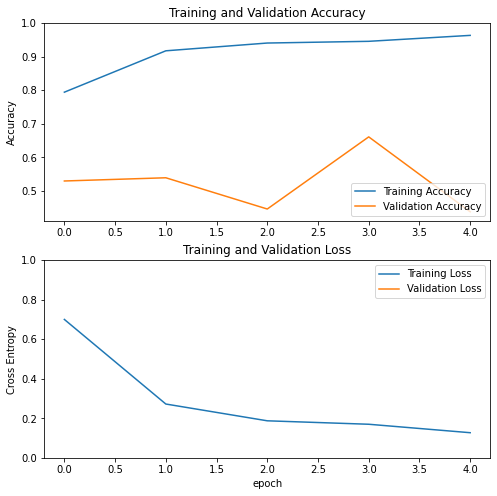

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [11]:
base_model.trainable = True

In [12]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])
model.summary()
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 2,626,821
Trainable params: 2,230,277
Non-

In [ ]:
history_fine = model.fit(train_generator, 
                         epochs=5,
                         validation_data=val_generator)
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [15]:
labels =  ['daisy', 'Dandelion', 'Sunflower', 'Roses', 'Tulips']
with open('labels.txt','w') as f:
  f.write('\n'.join(labels))